# Final Report  

### **Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

## 1. Introduction



Higher education institutions worldwide are attempting to effectively address diverse student learning styles and academic performances to enhance the learning experience. One interesting topic to consider is the dropout rate within higher education along with exploration of its root causes. A key factor that affects college graduation rates is that students with better academic performance in high school are more likely to graduate from college. 

The goal of this project is to determine if students who dropped out had lower admission grades than the students who graduated. The Polytechnic Institute of Portalegre (IPP) has a dataset with student data from four schools in Portugal. It provides data on nationality, admission grades, and graduation status. To explore this goal, we have formulated the below research question:

**Research Question:** *Research Question: Is there enough evidence to suggest that admission grades of students who dropped out are lower than students who graduated?*

## 2. Methods and Results

In the plimenary results on the project proposal, we identified that the distribution of the sample was normally distributed.
We were also able to identify the point estimate for the mean in both the drop-outs and the graduated.


We plan to conduct a one-sided hypothesis test to examine if there is enough evidence to suggest that the admission grades of dropout students are lower than graduated students. This can be represented in the following hypothesis where $m_1$ is the mean admission grade of dropout students and $m_2$ is the mean admission grade of graduated students.

$H_0: m_1-m_2 = 0$

$H_1: m_1-m_2 < 0$

**Method outline:**
- Find point estimate
- Use the infer workflow to simulate from the null distribution
- Conduct hypothesis test with p-value using $\alpha = 0.05$
- To access results, use bootstrapping method and conduct hypothesis test with a 95% CI
- Compare and interpret results of the p-value and CI 

We start by loading libraries, setting the seed, and importing the dataset into a dataframe.

In [1]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

#Clean the data 
dropout_clean <- dropout_data %>% rename(Student_Status = Target, 
                                         Admission_Grade = Admission.grade) %>% #Rename 'Target' column
  mutate(Student_Status = as_factor(Student_Status)) %>% #Convert the 'Student_Status' column to a factor
  filter(Student_Status != "Enrolled") 

#Select only the Target column 
dropout_pop <- dropout_clean %>% select(Student_Status, Admission_Grade) %>%
    mutate(Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

,Student_Status,Admission_Grade
,<fct>,<dbl>
1,Dropout,127.3
2,Graduate,142.5
3,Dropout,124.8
4,Graduate,119.6
5,Graduate,141.5
6,Graduate,114.8


### Getting Point Estimate

In [3]:
estimate = dropout_pop |> group_by(Student_Status) |> summarize(point_estimate = mean(Admission_Grade))
estimate

Student_Status,point_estimate
<fct>,<dbl>
Dropout,124.9614
Graduate,128.7944


## Our Hypothesis - 

$H_0: m_d-m_g = 0$

$H_1: m_d-m_g < 0$

At signifiance level is $\alpha = 5%$.

Here $m_d$ is the mean grade of the dropout candiates and $m_g$ is the mean grade of graduate candidates. We will use 2 approaches, simulation and theory based.



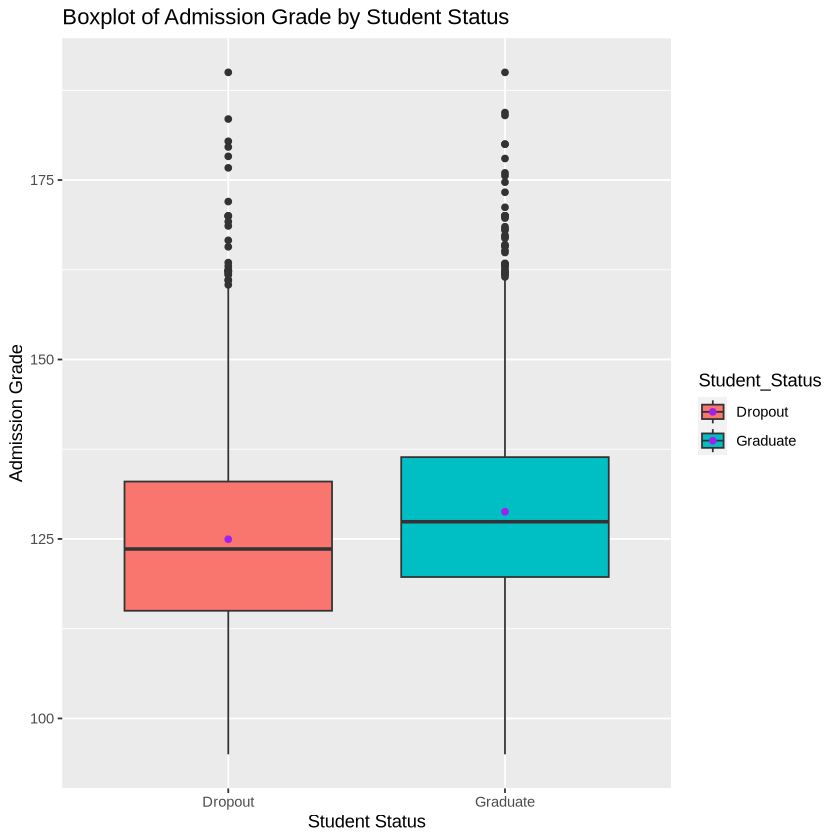

In [4]:
boxplot <-
    ggplot(dropout_pop, aes(x=Student_Status,y=Admission_Grade, fill=Student_Status)) + geom_boxplot() +
    stat_summary(fun = "mean", geom = "point", color = "purple") + 
    labs(title = "Boxplot of Admission Grade by Student Status",
    x = "Student Status",
    y = "Admission Grade")
boxplot

### Simulation based approach - 

In [5]:
test_stat <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%                         # Specifying the model.
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))   # Calculating the statistic.

test_stat

Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


stat
<dbl>
-3.833067


Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.
Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


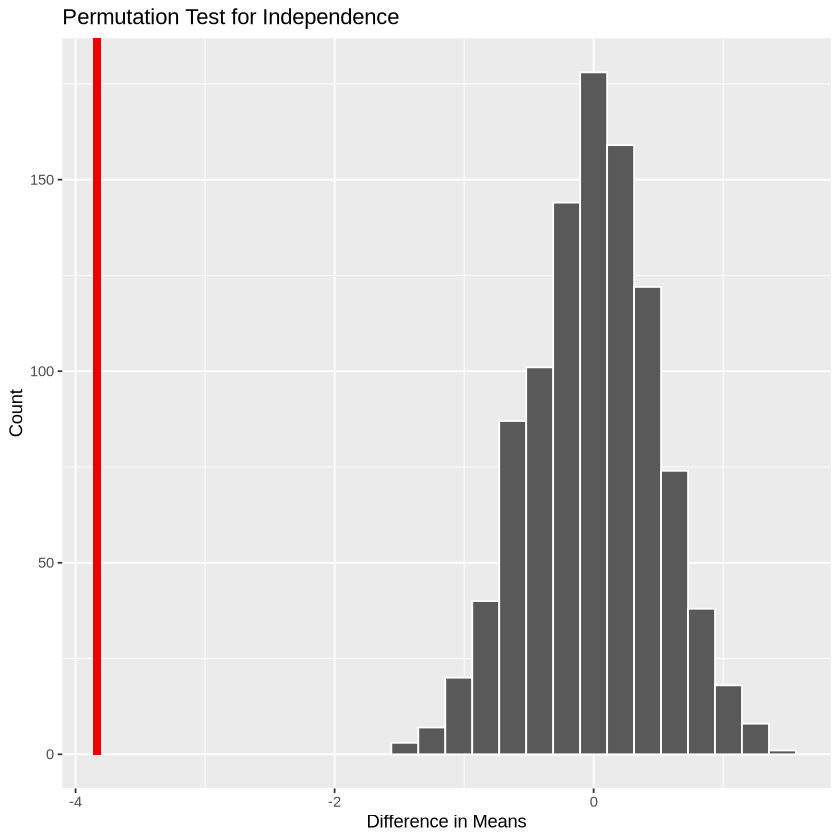

In [12]:
set.seed(2023);

null_dist <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%
  hypothesize(null="independence") %>%
  generate(type="permute", reps = 1000) %>%
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))

null_dist %>%
  visualize() +
  shade_p_value(obs_stat = test_stat, direction = "left") + 
  labs(title = "Permutation Test for Independence",
             x = "Difference in Means",
             y = "Count")

In [13]:
p_value <- null_dist %>%
  get_pvalue(obs_stat = test_stat, direction = "left")

p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


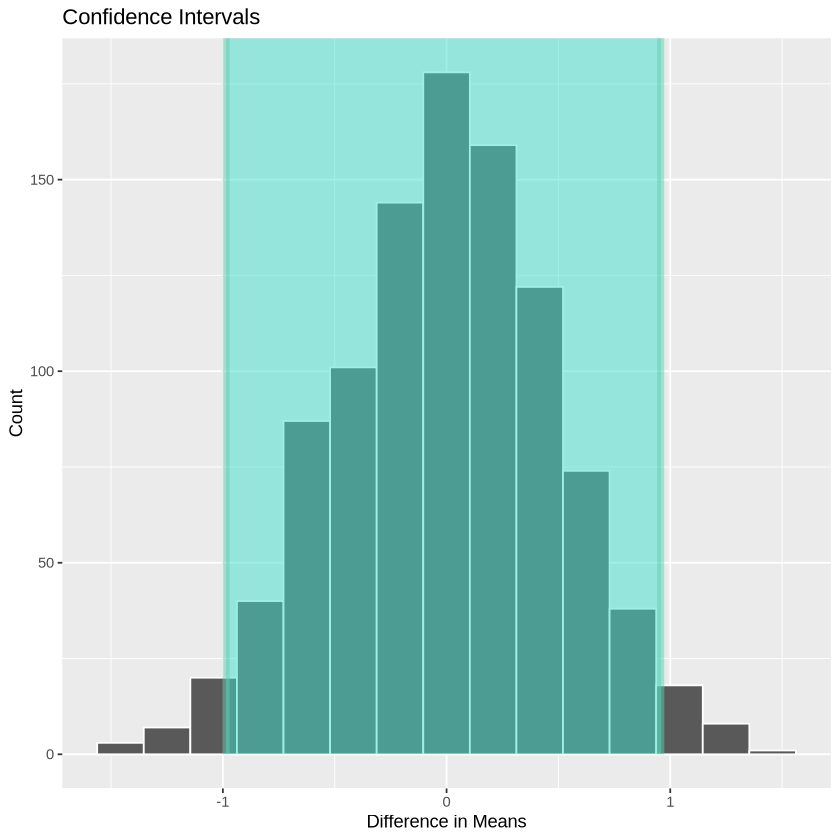

In [14]:
ci <- null_dist %>%
  get_ci(level = 0.95)

null_dist %>%
  visualize() +
  shade_ci(endpoints = ci, alpha=0.5) + xlab("Means Difference") + 
  labs(title = "Confidence Intervals",
             x = "Difference in Means",
             y = "Count")

Clearly the p-value $\le \alpha = 0.05$. This gives us reason to suggest that we should reject $H_o$

### Theory based approach -

We will start with the $T$ distribution statistic.

$T = \frac{(\bar{x}_d - \bar{x}_g)}{s_p \sqrt{\frac{1}{n_d} + \frac{1}{n_g}}}$ at $\alpha = 0.05$

$s_p = \sqrt{\frac{(n_d - 1)s_d^2 + (n_g - 1)s_g^2}{n_1 + n_2 - 2}}$

$df = n_d + n_d - 2$

In [9]:
# Assuming you have a dataframe named dropout_pop with columns Admission_Grade and Student_Status
group_d <- filter(dropout_pop, Student_Status == "Dropout")$Admission_Grade
group_g <- filter(dropout_pop, Student_Status == "Graduate")$Admission_Grade

# Calculate sample means
mean_d <- mean(group_d)
mean_g <- mean(group_g)

# Calculate sample standard deviations
sd_d <- sd(group_d)
sd_g <- sd(group_g)

# Calculating pooled standard deviation
sp <- sqrt(((length(group_d) - 1) * sd_d^2 + (length(group_g) - 1) * sd_g^2) / (length(group_d) + length(group_g) - 2))

# Calculate t-statistic
t_stat <- (mean_d - mean_g) / (sp * sqrt(1/length(group_d) + 1/length(group_g)))

# Calculate degrees of freedom
df <- length(group_d) + length(group_g) - 2

# Calculate p-value
p_value <- pt((t_stat), df)

# Display results
cat("t-value:", t_stat, "\n")
cat("p-value:", p_value, "\n")
cat("Degrees of freedom:", df, "\n")


t-value: -7.777318 
p-value: 4.791957e-15 
Degrees of freedom: 3628 


We will now use the $Z$ distribution statistic since the **degrees of freedom is very high and is practically the $Z$ distribution.** - 

$Z = \frac{\bar{x}_d - \bar{x}_g}{\sqrt{\frac{s_d^2}{n_d} + \frac{s_g2}{n_g}}}$ at $\alpha = 0.05$

In [10]:
n_d <- length(group_d)
n_g <- length(group_g)

# Two-sample z-test
z_value <- (mean_d - mean_g) / sqrt((sd_d^2 / n_d) + (sd_g^2 / n_g))

# Calculate p-value
p_value <- pnorm(z_value)
                 
cat("z-value:", z_value, "\n")
cat("p-value:", p_value, "\n")


z-value: -7.656517 
p-value: 9.552137e-15 


Again, as we can see, the p-value is close to 0. So clearly the p-value $\le \alpha = 0.05$. This gives us reason to suggest that we should reject $H_o$ in favour of $H_a$

This suggests that there is a statistically significant difference between the addmission grade of a dropout and graduate and we have resason to believe that graduates have a higher admission grade at a significance level $5$%

### will ask TA MONDAY 

In [11]:
drop <- dropout_pop %>% 
    filter(Student_Status == "Dropout")
grad <- dropout_pop %>% 
    filter(Student_Status == "Graduate")

test_t_test <- 
    broom::tidy(
        t.test(x = drop$Admission_Grade,
               y = grad$Admission_Grade,
               alternative = "less"))

test_t_test

group_d <- filter(dropout_pop, Student_Status == "Dropout")$Admission_Grade
group_g <- filter(dropout_pop, Student_Status == "Graduate")$Admission_Grade

mean_d <- mean(group_d)
mean_g <- mean(group_g)
sd_d <- sd(group_d)
sd_g <- sd(group_g)
n_d <- length(group_d)
n_g <- length(group_g)


# Two-sample z-test
t_value <- (mean_d - mean_g) / sqrt((sd_d^2 / n_d) + (sd_g^2 / n_g))

# degrees of freedom 
freedom <- ((sd_d^2/n_d)+(sd_g^2/n_g))^2/((sd_d^4/(n_d^2*(n_d-1)))+(sd_g^4/(n_g^2*(n_g-1))))

# t-test
p_val_t <- pt(t_value, df = freedom)
p_val_t

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-3.833067,124.9614,128.7944,-7.656517,1.296433e-14,2869.374,-Inf,-3.009341,Welch Two Sample t-test,less


[1] 1.296433e-14

# Refrences

Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.

Kantrowitz, M. (2021, November 19). Shocking statistics about college graduation rates. Forbes. https://www.forbes.com/sites/markkantrowitz/2021/11/18/shocking-statistics-about-college-graduation-rates/?sh=162e8c1f2b69

Chester Ismay and Albert Y. Kim. A ModernDive into R and the Tidyverse. https://moderndive.com/index.html